<a href="https://colab.research.google.com/github/hizmarck/hacking-civico/blob/master/proyecto/proyecto_hacking_civico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yucatán: Desnutrición.

Según la organización mundial de la salud la desnutricón es una de las malnutriciones con mayor repercusión en el desarrollo económico, social y médica a las que se enfrenta el mundo. [[1]](https://www.who.int/es/news-room/fact-sheets/detail/malnutrition)

En Yucatán se registraron en 2019 1689 casos de desnutrición; hoy en día con la pandemia por el COVID-19 se registran hasta 8 casos diarios de desnutrición dado que muchas familias han dejado de tener acceso a alimentos nutritivos. [[2]](https://www.yucatan.com.mx/salud/en-yucatan-hay-ocho-casos-diarios-de-desnutricion)

El presenta análisis buscará encontrar datos que revelen si la desnutrición ha ido en aumento o decremento y si en su caso existen programas de gobierno encaminados a atacar dicho problema.

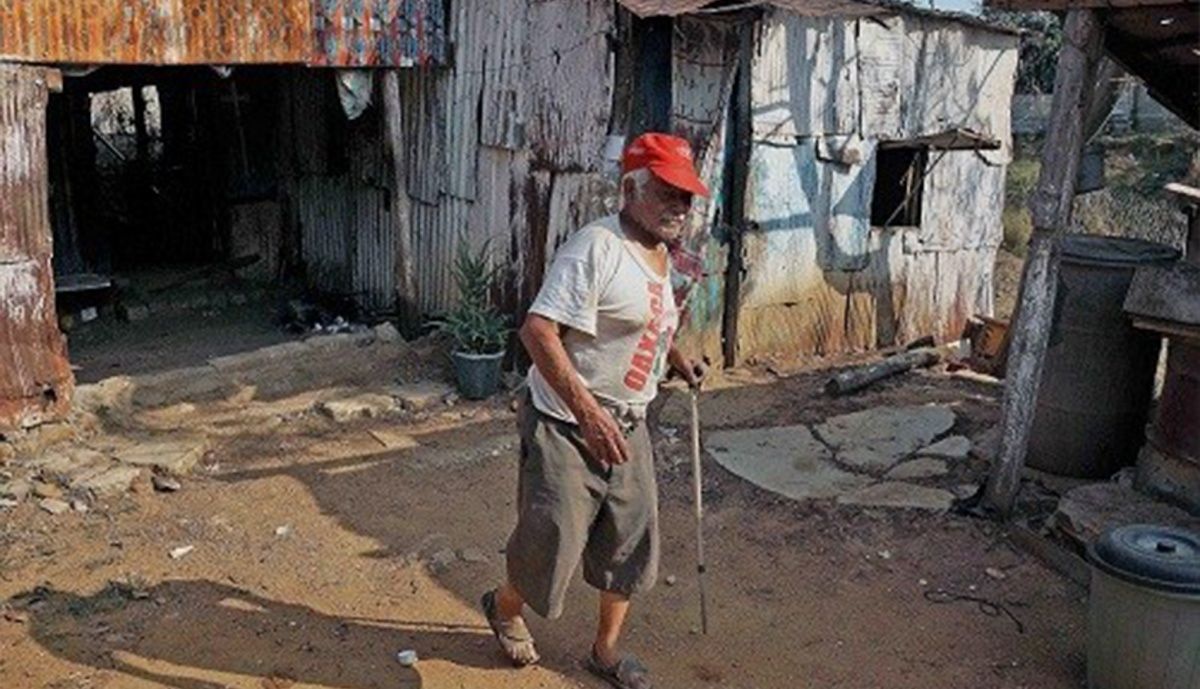



# Carga de Datos

En este apartado hacemos los pasos para cargar los datos desde una carpeta de google Drive, donde se encuentran en formato CSV los archivos descargados para su análisis. Así mismo se hace la importación de las liberias de Python a utilizar.



In [1]:
import altair as alt
import pandas as pd
import numpy as np

from google.colab import drive 
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
# load all paths

path = "/content/drive/My Drive/Colab Notebooks/data/proyecto_hacking_civico/"
pathFoodAidPrograms = path + "CS_AYUDA_ALIMENTARIA.csv"
pathCatalogues = path + "Catalogos_Entidades_Municipios.xlsx"
pathCataloguesEnsanut = path + 'ensanut_2018_programas_ayuda_alimentaria.Catálogo.xlsx';

In [3]:
# helper functions

def readCSVWithoutBlankSpaces(path, encoding = "ISO-8859-1"):
  _csv = pd.read_csv(path, encoding=encoding)
  _csv.columns = _csv.columns.str.replace(' ','_')
  _csv.columns = _csv.columns.str.replace(',','')
  return _csv


def loadXLSX(path, sheets):
  catalogues = {}
  for sheet in sheets:
    catalogue = pd.read_excel(path, sheet_name=sheet)
    catalogue.columns = catalogue.columns.str.replace(' ', '_')
    catalogue.columns = catalogue.columns.str.replace('.', '')
    catalogue.columns = catalogue.columns.str.lower()
    new_catalogue = {sheet: catalogue}
    catalogues.update(new_catalogue)
  return catalogues

# Obtención de datos.

Los datos fueron obtenidos de los siguiente sitios:



*   [Datos abiertos México](https://datos.gob.mx/) (Catálogo de Entidades y municipios).
*   [Encuenta Nacional de Salud y Nutrición](https://ensanut.insp.mx/index.php)

**Ensanut:** Es una iniciativa de la Secretaría de salud que inicio hace más de 25 años (hoy 2020) para la generación de un conjunto de datos fidedignos que permitieran conocer las condiciones de salud de la problación y sus tendencias, así como la utilización y percepción sobre servicios de salud.

He tomado para este pequeño análisis "*Cuestionario de programas de Ayuda alimentaria 2018*". Para este año ENSANUT encuestó 44064 hogares y 82 499 individuos.


In [4]:
#explorar los programas de ayuda alimentaría

foodAidPrograms = readCSVWithoutBlankSpaces(pathFoodAidPrograms)
foodAidPrograms.head()

UPM  VIV_SEL  HOGAR  NUMREN  ...  UPM_DIS  ESTRATO  F_AYUAL  MENORES_0_59
0   91        5      1       3  ...       91        3      210           2.0
1   91        5      1       4  ...       91        3      210           2.0
2   91        5      1       5  ...       91        3      210           2.0
3   91        5      1       6  ...       91        3      210           1.0
4   92        1      1       1  ...       92        4      272           2.0

[5 rows x 44 columns]

## Limpiar datos

Tomando los catálogos ofrecidos por ENSANUT se prosigue para hacer un match con cada parámetro, de esta forma se sustituyen las claves por texto legible para su análisis.

*Del archivo original he creado hojas por cada catálogo de esta manera es más fácil procesar los datos.*

In [5]:
# Cargar las entidades
sheets = ['ENTIDADES', 'MUNICIPIOS']
ensanutSheets = ['SI_NO', 'SI_NO_2', 'PROGRAMAS', 'SEXO']
catalogues = loadXLSX(pathCatalogues, sheets)
ensanutCatalogues = loadXLSX(pathCataloguesEnsanut, ensanutSheets)

dataFoodAidPrograms = (
    foodAidPrograms.merge(catalogues['ENTIDADES'], how="left", left_on="ENT", right_on="clave_entidad").
    drop(columns=['clave_entidad', 'abreviatura', 'ENT'])
    )

In [6]:
# Cargar SI_NO
sino_catalogues = ['P1','P2_1','P2_2','P3','P4','P5', 'P7', 'P9', 'P10', 'P12','P14','P15','P16','P17','P18','P19','P20','P21']

for col in sino_catalogues:
  dataFoodAidPrograms = (
      dataFoodAidPrograms.merge(ensanutCatalogues['SI_NO'], how='left', left_on=col, right_on='clave').
      drop(columns=[col, 'clave']).
      rename(columns={'descripción':col})
  )

In [7]:
# Cargar SI_NO2
sino2_catalogues = ['P6_1','P6_2','P6_3','P6_4','P6_5','P6_6','P6_7','P6_8']

for col in sino2_catalogues:
  dataFoodAidPrograms = (
      dataFoodAidPrograms.merge(ensanutCatalogues['SI_NO_2'], how='left', left_on=col, right_on='clave').
      drop(columns=[col, 'clave']).
      rename(columns={'descripción':col})
  )

In [8]:
# Programas

programs_catalogues = ['P8','P11','P13','P22_1']

for col in programs_catalogues:
  dataFoodAidPrograms = (
      dataFoodAidPrograms.merge(ensanutCatalogues['PROGRAMAS'], how='left', left_on=col, right_on='clave').
      drop(columns=[col, 'clave']).
      rename(columns={'descripción':col})
  )

In [9]:
# SEXO

dataFoodAidPrograms = (
    dataFoodAidPrograms.merge(ensanutCatalogues['SEXO'], how='left', left_on='SEXO', right_on='clave').
    drop(columns=['clave', 'SEXO']).
    rename(columns={'descripción':'SEXO'})
)

## Datos listos para procesamiento

Este es el resultado de la unión de todos los catálogos con los datos de **ENSANUT**.


In [21]:
# datos limipios y unidos con catálgos.

dataFoodAidPrograms.head(2)

id  UPM  ...         P22_1    SEXO
0   1   91  ...  NO RESPONDÍO  HOMBRE
1   2   91  ...  NO RESPONDÍO   MUJER

[2 rows x 45 columns]

# Exploración ENSANUT

De los programas de ayuda alimentaria tenemos las siguientes claves de preguntas, si se observa la información optenida de datos limipios podemos ver columnas con este tipo de claves (P1 ... P22_1), estas corresponden a la siguiente lista de preguntas que se hizo a la población Méxicana.

<table>
<thead>
  <tr>
    <th>Nemónico</th>
    <th>Pregunta</th>
  </tr>
</thead>
<tbody>
<tr><td>P1</td><td>¿(NOMBRE) recibe o recibió despensa de alimentos o apoyos alimentarios del DIF?</td></tr>

<tr><td>P2_1</td><td>¿(NOMBRE) asiste o asistió a comedores comunitarios 
A) del DIF?</td></tr>

<tr><td>P2_2</td><td>¿(NOMBRE) asiste o asistió a comedores comunitarios 
B) de SEDESOL?</td></tr>

<tr><td>P3</td><td>(NOMBRE) recibe o recibió apoyo de PROSPERA Programa de Inclusión Social (antes Oportunidades)</td></tr>

<tr><td>P4</td><td>¿(NOMBRE) recibe o recibió leche LICONSA (líquida o en polvo)?</td></tr>

<tr><td>P5</td><td>¿(NOMBRE recibe o recibió apoyo de Organizaciones No Gubernamentales (ONG´s)?</td></tr>

<tr><td>P6_1</td><td>¿Qué apoyo recibe de las Organizaciones No Gubernamentales (ONG´s)?
1 Leche</td></tr>
<tr><td>P6_2</td><td>2 Alimentos preparados</td></tr>
<tr><td>P6_3</td><td>3 Despensas</td></tr>
<tr><td>P6_4</td><td>4 Suplementos alimenticios para niños</td></tr>
<tr><td>P6_5</td><td>5 Pastillas o jarabes de vitaminas / minerales</td></tr>
<tr><td>P6_6</td><td>6 Apoyo económico para la producción de alimentos</td></tr>
<tr><td>P6_7</td><td>7 Otro (especifica)</td></tr>
<tr><td>P6_8</td><td>9 No sabe</td></tr>
<tr><td>P7</td><td>¿(NOMBRE) recibe o recibió suplementos de vitamina A?</td></tr>
<tr><td>P8</td><td>¿Qué programa o institución se lo entrega o entregó</td></tr>
<tr><td>P9</td><td>¿(NOMBRE) tiene servicio de estancia infantil de SEDESOL  para madres trabajadoras?</td></tr>

<tr><td>P10</td><td>¿(NOMBRE) recibe o recibió suplementos con hierro?</td></tr>

<tr><td>P11</td><td>¿Qué programa o institución se lo entrega o entregó?</td></tr>

<tr><td>P12</td><td>¿(NOMBRE) recibe o recibió ácido fólico?</td></tr>

<tr><td>P13</td><td>¿Quién se los entregó o entregaba?</td></tr>

<tr><td>P14</td><td>¿(NOMBRE) recibe o recibió desayunos escolares (fríos o calientes) del DIF?</td></tr>

<tr><td>P15</td><td>¿(NOMBRE) tiene servicio de alimentos del programa Escuelas de Tiempo Completo de la SEP?</td></tr>

<tr><td>P16</td><td>¿(NOMBRE) recibe o recibió apoyo alimentario de albergues escolares indígenas?</td></tr>

<tr><td>P17</td><td>¿(NOMBRE) recibe o recibió apoyo por parte del Programa de Atención a Jornaleros Agrícolas?</td></tr>

<tr><td>P18</td><td>¿(NOMBRE) recibe o recibió apoyo del Programa de Empleo Temporal?</td></tr>

<tr><td>P19</td><td>¿(NOMBRE) recibe o recibió capacitación para la implementación de huertos familiares?</td></tr>

<tr><td>P20</td><td>¿(NOMBRE) recibe o recibió capacitación y/o apoyo económico para implementar proyectos productivos?</td></tr>

<tr><td>P21</td><td>¿(NOMBRE) recibe o recibió apoyo monetario destinado a la alimentación/ nutrición de los adultos mayores?</td></tr>

<tr><td>P22_1</td><td>¿Qué programa o institución se lo entrega o entregó?</td></tr>

</tbody>
</table>

Analicemos el número de personas que reciben ayuda de los siguientes items:

*   **P1** - DIF
*   **P3** - Prospera (Oportunidades)
*   **P4** - Leche Liconsa



In [ ]:
# ¿Proporcion de personas que asegurán recibir ayuda del DIF (P1) en México?

dataFoodAidPrograms['P1'].value_counts(normalize=True)

NO         0.985393
SI         0.014080
NO SABE    0.000527
Name: P1, dtype: float64

In [ ]:
# ¿Proporción de personas que asegurán recibir ayuda del DIF (P1) en Yucatán.

dataFoodAidPrograms[dataFoodAidPrograms.entidad_federativa == 'YUCATÁN'].groupby('entidad_federativa')['P1'].value_counts(normalize=True)

entidad_federativa  P1     
YUCATÁN             NO         0.977982
                    SI         0.021617
                    NO SABE    0.000400
Name: P1, dtype: float64

In [ ]:
# ¿Proporcion de personas que asegurán recibir ayuda del Programa Prospera - Antes Oportunidades - (P3)?

dataFoodAidPrograms['P3'].value_counts(normalize=True)

NO         0.901959
SI         0.097521
NO SABE    0.000520
Name: P3, dtype: float64

In [ ]:
# ¿Proporción de personas que asegurán recibir ayuda del Programa Prospera - Antes Oportunidades - (P3) en Yucatán?

dataFoodAidPrograms[dataFoodAidPrograms.entidad_federativa == 'YUCATÁN'].groupby('entidad_federativa')['P3'].value_counts(normalize=True)

entidad_federativa  P3     
YUCATÁN             NO         0.88711
                    SI         0.11249
                    NO SABE    0.00040
Name: P3, dtype: float64

In [ ]:
# ¿Proporcion de personas que asegurán recibir ayuda del Programa Liconsa en México- (P4)?

dataFoodAidPrograms['P4'].value_counts(normalize=True)

NO         0.972493
SI         0.027113
NO SABE    0.000393
Name: P4, dtype: float64

In [ ]:
# ¿Proporción de personas que asegurán recibir ayuda del Programa Liconsa - (P4) en Yucatán?

dataFoodAidPrograms[dataFoodAidPrograms.entidad_federativa == 'YUCATÁN'].groupby('entidad_federativa')['P4'].value_counts(normalize=True)

entidad_federativa  P4     
YUCATÁN             NO         0.976381
                    SI         0.021617
                    NO SABE    0.002002
Name: P4, dtype: float64

# Visualización de los datos

Ahora visualizaremos las proporciones de datos para los programas alimenticios en Yucatán.

**Nota:** *Por el tamaña tan grande del dataset, es imposible para altair hacer gráficas sobre todo México, por ello filtre solo los resultados para Yucatán.*

In [50]:
# filtrar solo yucatán
yucatan = dataFoodAidPrograms[(dataFoodAidPrograms.SEXO == 'HOMBRE') & (dataFoodAidPrograms.entidad_federativa == 'YUCATÁN')]
yucatan.head(1)

id   UPM  VIV_SEL  ...           P13         P22_1    SEXO
91653  91654  3807       10  ...  NO RESPONDÍO  NO RESPONDÍO  HOMBRE

[1 rows x 45 columns]

In [49]:
# DIF barras
alt.Chart(yucatan).mark_bar().encode(
    x = alt.X("P1:N", title="P1"),
    y = alt.Y("count(P1):Q", title="Total de personas"),
    color = alt.Color("P1:N", 
                      legend=None, 
                      scale=alt.Scale(scheme='set3'))
).properties(
    title = "P1. ¿(NOMBRE) recibe o recibió despensa de alimentos o apoyos alimentarios del DIF?",
    width = 450
)

alt.Chart(...)

In [51]:
# Prospera barras
alt.Chart(yucatan).mark_bar().encode(
    x = alt.X("P3:N", title="P3"),
    y = alt.Y("count(P3):Q", title="Total de personas"),
    color = alt.Color("P3:N", 
                      legend=None, 
                      scale=alt.Scale(scheme='set3'))
).properties(
    title = "P3. (NOMBRE) recibe o recibió apoyo de PROSPERA Programa de Inclusión Social (antes Oportunidades)",
    width = 450
)

alt.Chart(...)

In [52]:
# Liconsa barras
alt.Chart(yucatan).mark_bar().encode(
    x = alt.X("P4:N", title="P4"),
    y = alt.Y("count(P4):Q", title="Total de personas"),
    color = alt.Color("P4:N", 
                      legend=None, 
                      scale=alt.Scale(scheme='set3'))
).properties(
    title = "P3. (NOMBRE) recibe o recibió apoyo de PROSPERA Programa de Inclusión Social (antes Oportunidades)",
    width = 450
)

alt.Chart(...)

# Conclusiones

Como gobierno puedo afirmar que los programas alimentarios son la primera linea de defensa que se usa encontra de la desnutrición.

De acuerdo a ENSANUT 2018 el programa en el que más participan en Yucatán es *PROSPERA* con un **11%** de los encuestados, superando incluso el porcentaje nacional de **9%**. 

**Notas:** *La encuesta ENSANUT están grande que creo que el presente análisis aún es muy inconcluso, falta aplicar una comparativa contra ENSANUT 2012 y pudiera ser ENSANUT 2006 dependiendo si existen preguntas similares.*

# Referencias



1.   [ENSANUT 2018](https://ensanut.insp.mx/encuestas/ensanut2018/descargas.php)
2.   [OMS](https://www.who.int/nutrition/es/)

